In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch_moving_mnist.data import MovingMNIST
from torch_moving_mnist.utils import show_images

from conv_lstm import Seq2Seq, device

import wandb
from tqdm.auto import tqdm

In [2]:
wandb.init(project="next-frame-prediction", entity="wandb")

config = wandb.config
config.num_frames = 4
config.num_frames = 4
config.num_digits = [3]
config.image_size = 64
config.batch_size = 4
config.affine_params = dict(
    angle=(-20, 20),  # rotation in degrees (min and max values)
    translate=((-30, 30), (-30, 30)),  # translation in pixels x and y
    scale=(0.8, 1.3),  # scaling in percentage (1.0 = no scaling)
    shear=(-20, 20),  # deformation on the z-plane
)

config.model_num_channels = 1
config.model_num_kernels = 64
config.model_kernel_size = 3
config.model_padding = 1
config.model_activation = "relu"
config.model_num_layers = 3

config.learning_rate = 1e4
config.epochs = 100

wandb: Currently logged in as: geekyrakshit (wandb). Use `wandb login --relogin` to force relogin


New computed stats for MovingMNIST: ([0.07522265625], [0.17685937499999999])


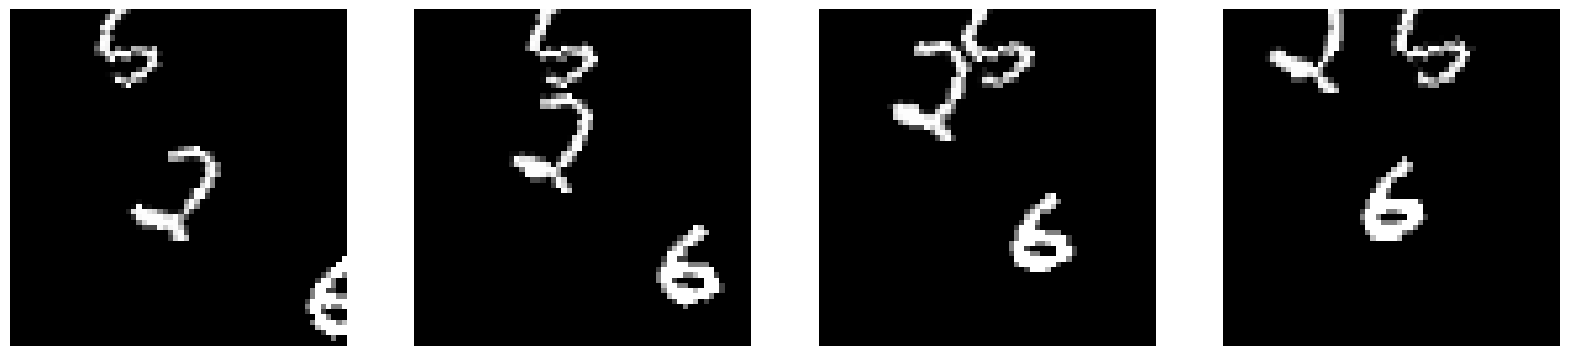

In [3]:
dataset = MovingMNIST(
    path=".",
    affine_params=config.affine_params,
    num_digits=config.num_digits,
    num_frames=config.num_frames,
    img_size=config.image_size,
    concat=True,
    normalize=True,
)
show_images(dataset[0], figsize=(20, 10))

In [4]:
model = Seq2Seq(
    num_channels=config.model_num_channels,
    num_kernels=config.model_num_kernels,
    kernel_size=(config.model_kernel_size, config.model_kernel_size),
    padding=(config.model_padding, config.model_padding),
    activation=config.model_activation,
    frame_size=(config.image_size, config.image_size),
    num_layers=config.model_num_layers,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=config.learning_rate)
criterion = nn.BCELoss(reduction="sum")

In [5]:
def get_batch(dataset, batch_size, num_frames):
    batch = torch.permute(dataset.get_batch(bs=batch_size), (0, 2, 1, 3, 4)).to(device)
    input_frames = batch[:, :, :num_frames - 1, :, :]
    target_frame = batch[:, :, num_frames - 1:, :, :]
    return input_frames, target_frame

In [6]:
input_frames, target_frame = get_batch(
    dataset, batch_size=config.batch_size, num_frames=config.num_frames
)

for epoch in tqdm(range(1, config.epochs), desc="Training"):
    model.train()
    predicted_frame = model(input_frames)
    loss = criterion(predicted_frame.flatten(), target_frame.flatten())
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    wandb.log({"Loss": float(loss.item())})

Training:   0%|          | 0/99 [00:00<?, ?it/s]

RuntimeError: cuDNN error: CUDNN_STATUS_INTERNAL_ERROR

In [ ]:
wandb.finish()